In [133]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit

from theano import tensor as tt

from causalgraphicalmodels import CausalGraphicalModel
import daft

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [134]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std() 

## Ex. 1

The data in data(bangladesh) are 1934 women from the 1989 Bangladesh Fertility Survey. For each woman, we know which district she lived in, her number of living.children, her age.centered, whether she lived in an urban center, and finally whether or not she used contraception (use.contraception).
In this first problem, I only want you to investigate the proportion of women using contraception in each district. Use partial pooling (varying effects). Then compare the varying effect estimates to the raw empirical proportion in each district. Explain the differences between the estimates and the data.

In [136]:
df = pd.read_csv('data/bangladesh.csv', sep=';')
print(df.shape)
df.head()

(1934, 6)


,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


Model definition 

\begin{split}\begin{aligned}
S_i  &\sim Bernoulli(p_i) \\
logit(p_i) &= \alpha_D[_i] \\
\alpha_j &\sim Normal(\bar{\alpha}, \sigma) \\
\bar{\alpha} &\sim Normal(0, 1.5) \\
\sigma &\sim Exponential(1) \\


\end{aligned}\end{split}




In [137]:
df['district_id'] = pd.factorize(df.district)[0]
district_idx = pd.factorize(df.district)[1]

In [138]:

with pm.Model() as m_7_1:
    #hyperprior
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1)

    a = pm.Normal('a', a_bar, sigma, shape=len(district_idx)+1)
    p = pm.math.invlogit(a[df['district_id']])

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])
    trace_7_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [139]:
with m_7_1:
    sum = az.summary(trace_7_1, round_to=2)
sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.54,0.09,-0.70,-0.38,0.00,0.00,2659.59,2516.40,1.00
a[0],-0.99,0.19,-1.37,-0.63,0.00,0.00,6272.38,2728.83,1.00
a[1],-0.59,0.34,-1.23,0.05,0.00,0.00,6078.13,2587.29,1.00
a[2],-0.23,0.50,-1.14,0.76,0.01,0.01,6788.41,3162.92,1.00
a[3],-0.18,0.30,-0.73,0.39,0.00,0.00,6197.63,2899.10,1.00
a[4],-0.58,0.28,-1.10,-0.06,0.00,0.00,7188.43,2974.94,1.00
a[5],-0.82,0.24,-1.24,-0.37,0.00,0.00,7836.02,3050.54,1.00
a[6],-0.76,0.37,-1.50,-0.09,0.00,0.00,6932.29,2920.03,1.00
a[7],-0.52,0.29,-1.09,0.01,0.00,0.00,8049.97,2819.70,1.00
a[8],-0.71,0.35,-1.39,-0.11,0.00,0.00,6819.47,3067.89,1.00


In [140]:
#extract hdis for each datapoint
hdi_low = []
hdi_high = []
for x in range(len(district_idx)+1):
    y = az.hdi(expit(trace_7_1['a'][:,x]))[0]
    z = az.hdi(expit(trace_7_1['a'][:,x]))[1]
    hdi_low.append(y)
    hdi_high.append(z)


In [141]:
df_grouped = df.groupby('district_id').agg({'use.contraception':'mean'}).reset_index()

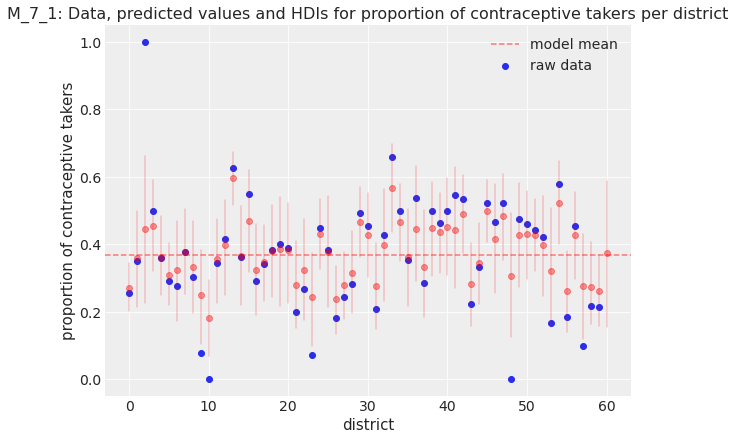

In [142]:
#visualize data and HDIs

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df_grouped['district_id'], df_grouped['use.contraception'], label='raw data') #real data

for x in range(len(district_idx)+1):
    ax.scatter(x, expit(trace_7_1['a'][:,x]).mean(), color='r', alpha=0.4) # mean predictions


for x, lower, upper in zip(range(len(district_idx)+1), hdi_low, hdi_high):
    ax.plot((x, x), (lower, upper), color='r', alpha=0.2)

ax.axhline(y=expit(trace_7_1['a_bar']).mean(), linestyle='dashed', color='r', alpha=0.5, label='model mean')
ax.set(title='M_7_1: Data, predicted values and HDIs for proportion of contraceptive takers per district',xlabel='district',ylabel='proportion of contraceptive takers')

ax.legend()


Conclusions from plotting the raw data and model predictions:
- Due to partial pooling, the predictions for the more extreme values shrink to the average model mean. 
- for one district with missing data (the last datapoint in the viz), mean and SD are also predicted by the model based on overall mean. One of the advantages of such models is that we can estimate even such districts for which we do not have any data (or have very little data).

## Ex. 2

First, draw a DAG that includes all five variables: \
(1) Uses contraception C \
(2) Age A \
(3) Children K \
(4) Urban U \
(5) District D

You don’t have to be an expert on fertility. But do think about which variables can influence which other variables.

Second, design an estimation strategy to identify both the total and direct causal effects of living in an urban center on contraceptive use. Those are your estimands. Consider causal relationships among the variables. Then use your DAG to justify an adjustment set that will yield the estimate of the causal effect of urban living on contraceptive use.

<Axes:>

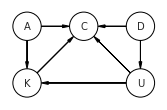

In [143]:
dag = CausalGraphicalModel(
    nodes=["C", "A", "K", "U", "D"],
    edges=[
        ("D", "U"),
        ("A", "K"),
        ("A", "C"),
        ("K", "C"),
        ("D", "C"),
        ("U", "C"),
        ("U", "K")

    ],
)
pgm = daft.PGM()
coordinates = {
    "C": (3, 2),
    "A": (2, 2),
    "K": (2, 1),
    "U": (4, 1),
    "D": (4, 2),

}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

Adjustment set for the total causal effect of U on C:
- D (to block the backdoor path)


Adjustment set for the direct causal effect of U on C:
- D (to block the backdoor path)
- K (to stratify by it)
- A (to block the collider path opened when including K )

# Ex. 3

Now build one or more statistical models to estimate the total and the direct causal effects of urban living on contraceptive use. Again include district as a simple varying effect (as in problem 1) so that each district has its own average contraceptive use. 

You may also want to stratify the effect of urban living by district. 

If you do, think carefully about how to do this statistically.

In [144]:
df.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_id
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


## a) Estimate total causal effect

#### First model: 
- adding one parameter to the previous districts-based model, measuring the **average effect** (accross all district) of living in an urban area.

In [145]:
df.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_id
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


In [146]:
#preprocess data
district_id = df.district_id.values
district_idx = pd.factorize(df.district)[1]

urban_id = df.urban.values
urban_idx = pd.factorize(df.urban)[1]

In [147]:
with pm.Model() as m_7_2_simple:
    #hyperprior
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1)

    b =  pm.Normal("b", 0.0, 0.5)

    #intercept for each of distric  ts
    a = pm.Normal('a', a_bar, sigma, shape=len(district_idx))

    #linear model with link function
    p = pm.math.invlogit(a[district_id] + b*urban_id)

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])

    trace_7_2_simple = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [148]:
with m_7_2_simple:
    sum = az.summary(trace_7_2_simple, round_to=2, var_names=['b', 'a_bar', 'sigma'])
sum    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.62,0.11,0.40,0.83,0.0,0.0,2396.92,3047.65,1.0
a_bar,-0.69,0.09,-0.85,-0.54,0.0,0.0,2099.96,2803.01,1.0
sigma,0.46,0.08,0.30,0.60,0.0,0.0,1102.96,1468.07,1.0


Since the b parameter has a positive value, we can conclude that living in an urban area has positive effect on the probability of taking contraceptions.


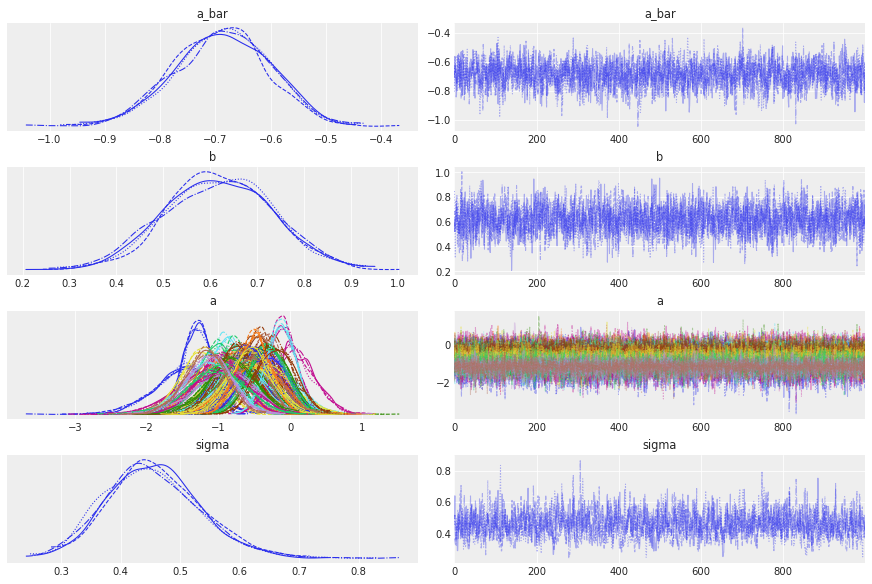

In [149]:
with m_7_2_simple:
    az.plot_trace(trace_7_2_simple)

#### Second model: 
- in the second model, we will allow the effect of living in an urban area to vary accross districts.

In [150]:

with pm.Model() as m_7_2_simple2:
    #hyperprior
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma_a = pm.Exponential("sigma_a", 1)

    b_bar = pm.Normal("b_bar", 0.0, 0.5)
    sigma_b = pm.Exponential("sigma_b", 1)

    #intercept for each of distric  ts
    a = pm.Normal('a', a_bar, sigma_a, shape=len(district_idx))
    b = pm.Normal('b', b_bar, sigma_b, shape=len(district_idx))


    #linear model with link function
    p = pm.math.invlogit(a[district_id] + b[district_id]*urban_id)

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])

    trace_7_2_simple2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, b_bar, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7128717575668343, but should be close to 0.8. Try to increase the number of tuning steps.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


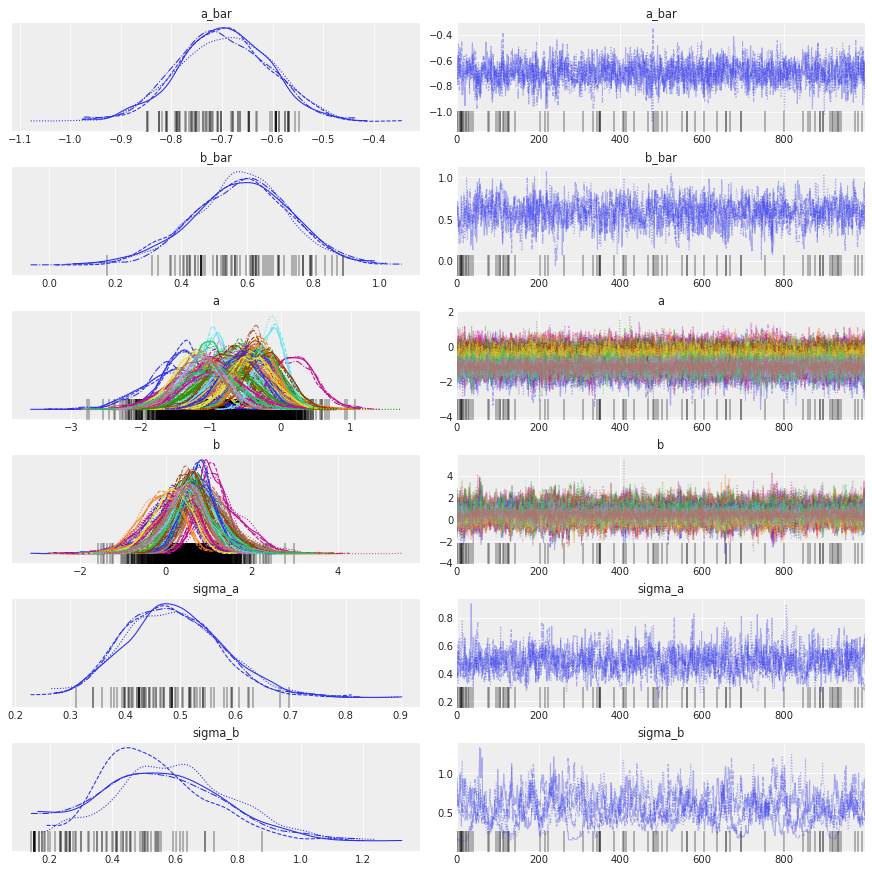

In [151]:
with m_7_2_simple2:
    az.plot_trace(trace_7_2_simple2)

Sigma b did not sample really well, so we will try to reparametrize the model.

In [159]:

with pm.Model() as m_7_2_simple2_non_centered:
    #hyperprior
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma_a = pm.Exponential("sigma_a", 1)

    b_bar = pm.Normal("b_bar", 0.0, 0.5)
    sigma_b = pm.Exponential("sigma_b", 1)

    #varying intercepts
    z_a = pm.Normal("z_a", 0.0, 1.0, shape=len(district_idx))

    #varying slopes
    z_b = pm.Normal("z_b", 0.0, 1.0, shape=len(district_idx))

    #linear model with link function
    p = pm.math.invlogit(
        (a_bar + z_a[district_id] * sigma_a) + (b_bar + z_b[district_id] * sigma_b) * urban_id
        )

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])

    trace_7_2_simple2_non_centered = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_b, z_a, sigma_b, b_bar, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


There are no divergences and the numebr of effective samples increased from <10% to <25%, so the reparametrization brought an improvement.
Let´s plot the traces to check:

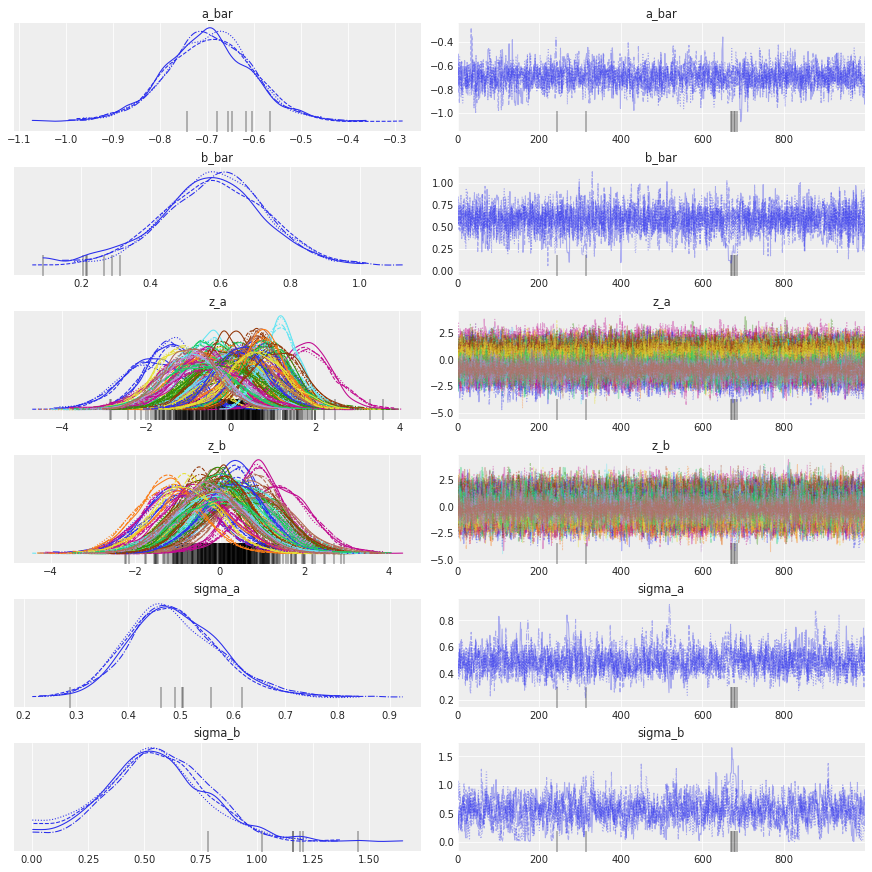

In [160]:
with m_7_2_simple2_non_centered:
    az.plot_trace(trace_7_2_simple2_non_centered)

In [161]:
with m_7_2_simple2_non_centered:
    sum = az.summary(trace_7_2_simple2_non_centered, var_names=["a_bar", "b_bar", "sigma_a", "sigma_b"])
sum    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.696,0.091,-0.886,-0.537,0.002,0.001,1943.0,2000.0,1.00
b_bar,0.579,0.148,0.301,0.863,0.004,0.003,1618.0,560.0,1.00
sigma_a,0.488,0.089,0.326,0.655,0.003,0.002,1145.0,1375.0,1.00
sigma_b,0.547,0.228,0.098,0.973,0.009,0.007,641.0,675.0,1.01


#### Third model: 
- in the third model, we will try to capture the covariation between the intercept (average probability per district) and the slope (effect of living in an urban area)

Model definition 

\begin{split}
S_i  &\sim Bernoulli(p_i) \\
logit(p_i) &= \alpha_{\text{D[i]}}  + \beta_{\text{D[i], U}[i]} \\
\end{split}

\begin{bmatrix}\alpha_{\text{district}} \\ \beta_{\text{district, urban}} \end{bmatrix} \sim \left( \begin{bmatrix}\alpha \\ \beta \end{bmatrix} , \textbf{S} \right)  

S is a covariance matrix, which indicates how alpha and beta parameters relate to each other.

\begin{split}
\textbf{S} = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}
\end{split}

In [155]:

with pm.Model() as m_7_2_centered:
    #prior stddev in intercepts and slopes (variation accross districts)
    sd_dist = pm.Exponential.dist(0.5)

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)

    #prior for average intercept (by district)
    a = pm.Normal("a", mu=0, sd=1.5)

    #prior for average slope (difference between urban and non-urban)

    b = pm.Normal("b", mu=0, sd=1.5)

    # population of varying effects
    ab_district = pm.MvNormal(
        "ab_district", mu=tt.stack([a, b]), chol=chol, shape=(len(district_idx), 2)
    )
    # shape needs to be (number of districts, 2) because we're getting back both a and b for each district

    # link function

    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ab_district[district_id, 0] + ab_district[district_id, 1] * urban_id
        ),
    )

    c = pm.Bernoulli("c", p=p, observed=df["use.contraception"])


In [32]:
with m_7_2_centered:    
    m_7_2_centered_idata = pm.sample(
        2000,
        tune=2000,
        target_accept=0.99,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ab_district, b, a, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 618 seconds.
The number of effective samples is smaller than 10% for some parameters.


We are getting some warnings, so let´s reparametrize the model:


In [185]:

with pm.Model() as m_7_2_noncentered:
    #prior stddev in intercepts and slopes (variation accross districts)
    sd_dist = pm.Exponential.dist(0.5)

    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True)

    #prior for average intercept (by district)
    a = pm.Normal("a", mu=0, sd=1.5)
    #prior for average slope (difference between urban and non-urban)
    b = pm.Normal("b", mu=0, sd=1.5)

    # population of varying effects
    z = pm.Normal('z', 0.0, 1.0, shape=(2, len(district_idx)))

    ab_district = pm.Deterministic("ab_county", tt.dot(chol, z).T)
    # shape needs to be (number of districts, 2) because we're getting back both a and b for each district

    # link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            a + ab_district[district_id, 0] + (b + ab_district[district_id, 1]) * urban_id
        )
    )

    c = pm.Bernoulli("c", p=p, observed=df["use.contraception"])


In [186]:
with m_7_2_noncentered:    
    m_7_2_noncentered_idata = pm.sample(
        5000,
        tune=5000,
        target_accept=0.9,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, b, a, chol]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 129 seconds.


The warnings are gone, so hopefully we were able to improve the sampling.

In [187]:
with m_7_2_noncentered:
    sum = az.summary(m_7_2_noncentered_idata,var_names=['a','b','chol_stds','chol_corr'],round_to=2)
sum    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.71,0.10,-0.90,-0.51,0.0,0.0,10275.50,13572.08,1.0
b,0.71,0.17,0.39,1.04,0.0,0.0,12834.80,14682.54,1.0
chol_stds[0],0.59,0.10,0.41,0.78,0.0,0.0,8499.19,12656.67,1.0
chol_stds[1],0.81,0.21,0.43,1.21,0.0,0.0,6782.82,8683.60,1.0
"chol_corr[0, 0]",1.00,0.00,1.00,1.00,0.0,0.0,20000.00,20000.00,NaN
"chol_corr[0, 1]",-0.67,0.16,-0.92,-0.36,0.0,0.0,9546.28,14381.86,1.0
"chol_corr[1, 0]",-0.67,0.16,-0.92,-0.36,0.0,0.0,9546.28,14381.86,1.0
"chol_corr[1, 1]",1.00,0.00,1.00,1.00,0.0,0.0,19822.10,20000.00,1.0


Looking at the parameters, we see the following:
- the average influence of being in an urban center has slightly increased
- there seems to be a lot of variation between the effects of being in an urban center among individual districts
- intercept and slope are negatively correlated - meaning that if a district has high probability of taking contraception in the non-urban areas, the effect of living in an urban area will be smaller

Let´s try to plot trace to check sampling:

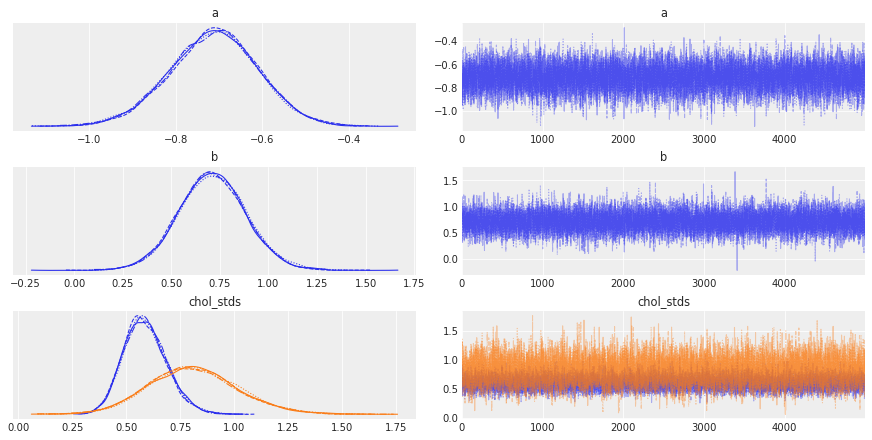

In [193]:
with m_7_2_noncentered:
    az.plot_trace(m_7_2_noncentered_idata,var_names=['a','b','chol_stds'])

There seems to be a problem plotting the trace for the correlation of the covariated effects. I will get back to the issue and try to fix it at a later stage.

#### Model selection
Let´s compare the well-behaving models we have so far:

In [162]:
df_comp_loo = az.compare(
    {
        "fixed slope": trace_7_2_simple, 
        "varying slope": trace_7_2_simple2_non_centered,
        "covariation": m_7_2_noncentered_idata
    }
        )
df_comp_loo

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
covariation,0,-1234.308646,52.769786,0.000000,1.000000e+00,14.074100,0.000000,False,log
varying slope,1,-1240.633070,48.098749,6.324424,4.468648e-14,13.633709,2.724829,False,log
fixed slope,2,-1245.321663,33.311536,11.013017,0.000000e+00,13.193644,4.575684,False,log


We see that the model with covariation is rated as the best one (despite the sampling problem), then comes the model with varying slope, followed by the fixed slope model.

## b) Estimate direct causal effect

In [120]:
df.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_id
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


In [122]:
age = df['age.centered'].values
children = df['living.children'].values

In [182]:
with pm.Model() as m_7_3:
    #hyperprior
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma = pm.Exponential("sigma", 1)

    #intercept for each of distric  ts
    a = pm.Normal('a', a_bar, sigma, shape=len(district_idx))

    #slope for urban
    b_u =  pm.Normal("b_u", 0.0, 0.5)

    #slope for age
    b_a =  pm.Normal("b_a", 0.0, 0.5)

    #slope for children
    b_k = pm.Normal("b_k", 0.0, 0.5)

    #children
    delta = pm.Dirichlet("delta", np.repeat(2.0, 4), shape=4)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    #linear model with link function
    p = pm.math.invlogit(a[district_id] + b_u * urban_id + b_a * age + b_k * delta_j_cumulative[children])

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])

    trace_7_3 = pm.sample(
        5000, 
        tune=5000,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, b_k, b_a, b_u, a, sigma, a_bar]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 93 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [183]:
with m_7_3:
    sum = az.summary(trace_7_3,var_names=['a_bar','b_u','b_a','b_k','sigma','delta'])
sum    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-1.693,0.179,-2.040,-1.369,0.004,0.003,1896.0,2789.0,1.0
b_u,0.676,0.115,0.463,0.892,0.001,0.001,16800.0,14523.0,1.0
b_a,-0.025,0.007,-0.038,-0.011,0.000,0.000,10019.0,12902.0,1.0
b_k,1.385,0.188,1.036,1.742,0.004,0.003,2003.0,3006.0,1.0
sigma,0.478,0.081,0.330,0.631,0.001,0.001,6556.0,8845.0,1.0
delta[0],0.113,0.069,0.005,0.239,0.001,0.001,4379.0,6954.0,1.0
delta[1],0.655,0.091,0.491,0.828,0.001,0.001,13595.0,14513.0,1.0
delta[2],0.151,0.074,0.014,0.280,0.000,0.000,21390.0,11644.0,1.0
delta[3],0.081,0.047,0.006,0.166,0.000,0.000,23318.0,15670.0,1.0


We are getting a sampling warning, so let´s try to reparametrize and include varying effects for the rest of the parameters at the same time:

In [178]:
with pm.Model() as m_7_3_noncentered:
    #hyperprior intercept
    a_bar = pm.Normal("a_bar", 0.0, 1)
    sigma_a = pm.Exponential("sigma_a", 1)

    #varying intercept
    z_a = pm.Normal("z_a", 0.0, 1.0, shape=len(district_idx))

    #slope for urban
    b_u_bar =  pm.Normal("b_u_bar", 0.0, 0.5)
    sigma_u = pm.Exponential("sigma_u", 1)
    
    z_u = pm.Normal("z_u", 0.0, 1.0, shape=len(district_idx))


    #slope for age
    b_a_bar =  pm.Normal("b_a_bar", 0.0, 0.5)
    sigma_age = pm.Exponential("sigma_age", 1)
    
    z_age = pm.Normal("z_age", 0.0, 1.0, shape=len(district_idx))

    #slope for children
    b_k_bar =  pm.Normal("b_k_bar", 0.0, 0.5)
    sigma_k = pm.Exponential("sigma_k", 1)
    
    z_k = pm.Normal("z_k", 0.0, 1.0, shape=len(district_idx))

    #children
    delta = pm.Dirichlet("delta", np.repeat(2.0, 4), shape=4)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)

    #linear model with link function
    p = pm.math.invlogit((a_bar + z_a[district_id]*sigma_a) + (b_u_bar + z_u[district_id]*sigma_u) * urban_id + (b_a_bar + z_age[district_id]*sigma_age) * age + (b_k_bar + z_k[district_id]*sigma_k) * delta_j_cumulative[children])

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])

    trace_7_3_noncentered = pm.sample(
        5000, 
        tune=5000,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, z_k, sigma_k, b_k_bar, z_age, sigma_age, b_a_bar, z_u, sigma_u, b_u_bar, z_a, sigma_a, a_bar]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 333 seconds.
The number of effective samples is smaller than 25% for some parameters.


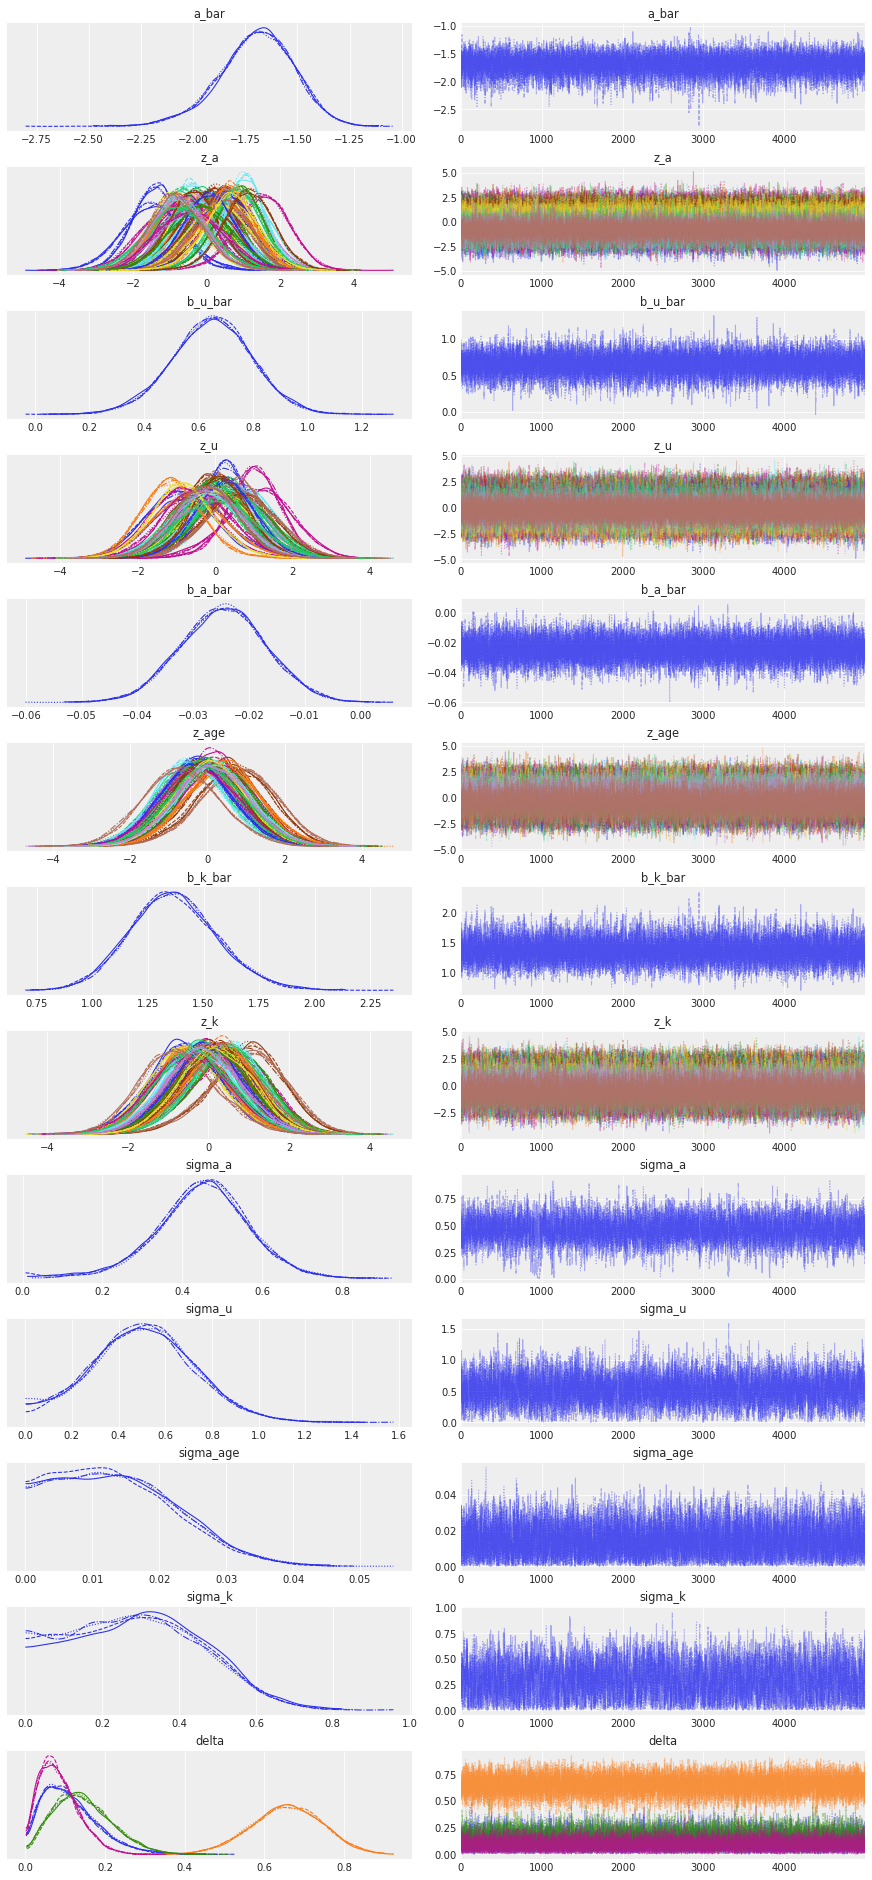

In [180]:
with m_7_3_noncentered: 
    az.plot_trace(trace_7_3_noncentered)

In [181]:
with m_7_3_noncentered:
    sum = az.summary(trace_7_3_noncentered, var_names=['delta', 'sigma_k', 'b_k_bar', 'sigma_age', 'b_a_bar', 'sigma_u', 'b_u_bar', 'sigma_a', 'a_bar'])
sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta[0],0.114,0.069,0.005,0.237,0.001,0.000,14499.0,12783.0,1.0
delta[1],0.655,0.089,0.492,0.827,0.001,0.000,22057.0,16984.0,1.0
delta[2],0.145,0.072,0.019,0.274,0.000,0.000,26979.0,12549.0,1.0
delta[3],0.085,0.049,0.006,0.175,0.000,0.000,23627.0,14501.0,1.0
sigma_k,0.290,0.168,0.000,0.555,0.003,0.002,2651.0,6361.0,1.0
b_k_bar,1.366,0.197,1.002,1.742,0.002,0.001,17660.0,12897.0,1.0
sigma_age,0.014,0.009,0.000,0.029,0.000,0.000,6835.0,10142.0,1.0
b_a_bar,-0.025,0.008,-0.039,-0.011,0.000,0.000,28363.0,16025.0,1.0
sigma_u,0.505,0.220,0.049,0.884,0.003,0.002,4574.0,4196.0,1.0
b_u_bar,0.648,0.147,0.365,0.922,0.001,0.001,23413.0,14920.0,1.0


Conclusion: 
- The direct effect is noch much different from the total effect.
- Age effect does not differ much among individual districts
- on the other hand, the effect of urban living varies a lot among individual districts